In [1]:
from dataclasses import dataclass
import sys

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, CenterCrop, Resize, Normalize
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW

from nuy_v2_loader import NYUV2Dataset
from stepper import Stepper, MultiTermLossStepper
from summary_writer import SummaryWriter, WandBSummaryWritter
from metrics import (
  absolute_relative_mean_error,
  root_mean_squared_error,
  average_absolute_log_error,
  threshold_acc
)
from loss import nyuv2_loss_fn, sil_loss, grad_l1_loss, nyuv2_multiterm_loss_fn, nyuv2_multiterm_loss_fn_vit
from models.res_refinet import Resnet101RefineNet
from models.compose_net import ComposeNet
from multiterm_optim import MultiTermAdam

In [2]:
####

In [3]:
@dataclass
class Namespace:
  name: str

In [4]:
# CONSTANTS
SEED = 43
EPSILON = 1e-7
BATCH_SIZE = 16
MAX_DATA_LENGHT = None

INPUT_SIZE=(224, 320)

RGB = Namespace(name='RGB')
RGB.mean = (0.4644, 0.3905, 0.3726) # Derived with utils.py
RGB.std = (0.2412, 0.2432, 0.2532) # Derived with utils.py

NYU_V2 = Namespace(name='NYU_V2')
NYU_V2.max = 10.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
np.random.seed(SEED)

In [6]:
# if not os.path.exists('datasets/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [6]:
NYU_V2_IMG_DIMENSION = (448, 608)

transforms = Compose([
  ToTensor(), CenterCrop(NYU_V2_IMG_DIMENSION), Resize(size=INPUT_SIZE),
])
rgb_t = Compose([
  transforms, Normalize(mean=RGB.mean, std=RGB.std)
])

train_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'train', download=True, max_lenght=MAX_DATA_LENGHT)
test_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'test', download=True, max_lenght=MAX_DATA_LENGHT)

Failed to load tar file
Finished loading dataset
Failed to load tar file
Finished loading dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


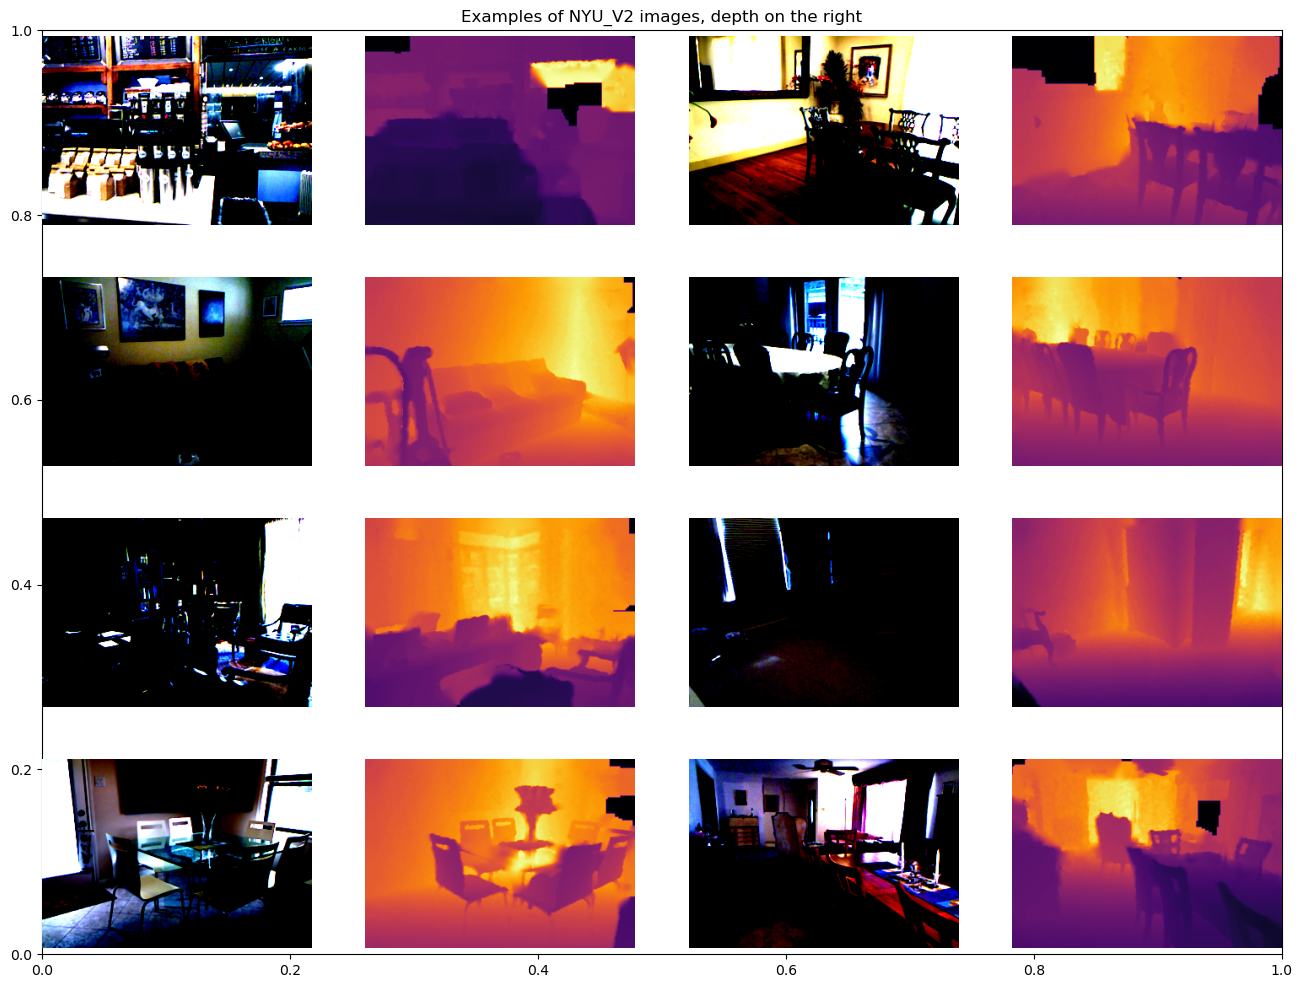

In [7]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [8]:
summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# resnet101_refinet = Resnet101RefineNet()
compose_net = ComposeNet(inputsize=INPUT_SIZE, channels=128)
# optim = Adam(resnet101_refinet.parameters(), lr=1e-4)
# stepper = Stepper(resnet101_refinet, optim=optim, loss_fn=nyuv2_loss_fn, summary_writter=summary_writer)
optim = AdamW(compose_net.parameters(), lr=1e-4)
# stepper = Stepper(compose_net, optim=optim, loss_fn=nyuv2_loss_fn, summary_writter=summary_writer)
stepper = Stepper(compose_net, optim=optim, loss_fn=nyuv2_loss_fn, summary_writter=summary_writer)
stepper.set_loaders(train_loader, val_loader)
stepper.to(device)

summary_writer.register(
  project='pure_depth',
  config={
    'architecture': 'ComposeNet',
    'optim': 'AdamW',
    # 'optim': 'Adam',
    'device': device,
    'batch_size': BATCH_SIZE,
    'loss_fn': stepper.loss_fn.__doc__
  }
)

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: percalee. Use `wandb login --relogin` to force relogin


In [10]:
# summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# resnet101_refinet = Resnet101RefineNet()
# optim = MultiTermAdam(resnet101_refinet.parameters(), lr=1e-4, betas=(0.8, 0.98, 0.7))
# stepper = MultiTermLossStepper(resnet101_refinet, optim=optim, loss_fn=nyuv2_multiterm_loss_fn, summary_writter=summary_writer)
# stepper.set_loaders(train_loader, val_loader)
# stepper.to(device)

# summary_writer.register(
#   project='pure_depth',
#   config={
#     'architecture': 'Resnet101_Refinet',
#     'optim': 'MultiTermAdam',
#     'device': device,
#     'batch_size': BATCH_SIZE,
#     'loss_fn': stepper.loss_fn.__doc__
#   }
# )

In [ ]:
# torch.autograd.set_detect_anomaly(True)
stepper.train(n_epochs=20)
stepper.save_checkpoint(file_name='artifacts/vit')

train step:  16%|█▋        | 489/2974 [08:59<45:22,  1.10s/batch, loss=0.249]

In [9]:
stepper.load_checkpoint('artifacts/vit')

In [1]:
# Just sanity check
x, y = train_dataset[40333]
stepper.model.eval()
pred = stepper.model(x.unsqueeze(0).to(device))

vmax = y.max()
plt.figure(figsize=(8, 6))
ax0 = plt.subplot(1, 2, 1)
show = ax0.imshow(
  np.transpose(pred[0].detach().cpu().numpy(), (1, 2, 0)),
  cmap='inferno'
)
plt.colorbar(show, ax=ax0)
ax1 = plt.subplot(1, 2, 2)
show = ax1.imshow(
  np.transpose(y.detach().numpy(), (1, 2, 0)), 
  cmap='inferno', 
  vmin=0
)
plt.colorbar(show, ax=ax1)

NameError: name 'train_dataset' is not defined

In [18]:
def evaluate_metrics(model: nn.Module, data_loader: DataLoader, summary_writer: SummaryWriter):
  running_metrics: np.array = None
  
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)

        metrics = np.array((
          absolute_relative_mean_error(pred, y_batch).item(),
          root_mean_squared_error(pred, y_batch).item(),
          average_absolute_log_error(pred, y_batch).item(),
          *(
            metric.item() 
            for metric 
            in threshold_acc(pred, y_batch)
          )
        )).reshape(1, -1)
        
        if running_metrics is None:
          running_metrics = metrics
        else:
          running_metrics = np.vstack((running_metrics, metrics))
  
  mean_metrics = np.mean(running_metrics, axis=0)
  summary_writer.track_object({
    'evaluation_metrics': {
      'absolute_relative_mean_error': mean_metrics[0],
      'root_mean_squared_error': mean_metrics[1],
      'average_absolute_log_error': mean_metrics[2],
      'threshold_accuracy_delta_1': mean_metrics[3],
      'threshold_accuracy_delta_2': mean_metrics[4],
      'threshold_accuracy_delta_3': mean_metrics[5]
    }
  })

evaluate_metrics(stepper.model, val_loader, summary_writer)

KeyboardInterrupt: 

In [ ]:
summary_writer.finalize()